# Artificial Neural Networks (CS-456)
## Miniproject 1: Tic Tac Toe
- Mickaël Achkar (322190)
- Yehya El Hassan (325932)


In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from typing import Dict, List
import hashlib
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

In [2]:
class RlAgent():
    def __init__(self,player:str,epsilon:float,learning_rate:float = 0.05,discount_factor:float = 0.99):
        # Choose the Player (X,O)
        self.player = player

        # Choose the exploration/exploitation factor
        self.epsilon = epsilon

        # RL training hyper params
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # Form the the q_table and initialize it to empty
        self.q_table:Dict[str,np.ndarray] = {}

        # Actions take values between 0 and 9 representing the possible positions on the board
        self.list_of_possible_actions:List[int] = [] 

        # Initialize the current reward
        self.reward = 0

        # Update current episode number
        self.current_episode = 0
        
    def observe_state(self, board):
        # Observe the current state of the environment
        self._update_board(board)
        self._update_list_of_possible_actions()

    def observe_reward(self,reward):
        # Observe the current reward from the environment
        self._update_reward(reward)

    def act(self, board: np.ndarray):
        # Sample from a uniform distribution
        current_state = self.get_state_key(board)
        if (random.uniform(0,1)<epsilon):
            return self._choose_random_action()
        else:
            return self._choose_best_action(current_state)

    def update_q_table(self,current_board_config, current_action, next_board_config, terminal_state = False):
        # update the q_table
        current_state = self.get_state_key(current_board_config)
        next_state = self.get_state_key(next_board_config)

        # create new entries if needed
        self._create_new_state_entries_if_needed(current_state)
        self._create_new_state_entries_if_needed(next_state)

        if not terminal_state:
            best_action = self._choose_best_action(next_state)
            self.q_table[current_state][current_action] = self.q_table[current_state][current_action] + self.learning_rate*(self.reward + self.discount_factor*(self.q_table[next_state][best_action]) - self.q_table[current_state][current_action])
        else:
            self.q_table[current_state][current_action] = self.q_table[current_state][current_action] + self.learning_rate*(self.reward - self.q_table[current_state][current_action])

    def _update_board(self,board):
        # Get's the latest board configuration from the Game
        self.board = board
    
    def _update_list_of_possible_actions(self):
        # Get's the available positions on the board
        available_actions = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if self.board[pos] == 0:
                available_actions.append(i)
        self.list_of_possible_actions = available_actions
        return self.list_of_possible_actions

    def _update_reward(self, reward):
        # Updates the current reward
        self.reward = reward

    def _choose_best_action(self, current_state):
        self._create_new_state_entries_if_needed(current_state)
        maximum_q_values_idx = np.where(self.q_table[current_state][self.list_of_possible_actions] == np.max(self.q_table[current_state][self.list_of_possible_actions]))[0]
        random_max = np.random.choice(maximum_q_values_idx)
        return (self.list_of_possible_actions[random_max])

    def _choose_random_action(self):
        return np.random.choice(self.list_of_possible_actions)

    def _create_new_state_entries_if_needed(self, state):
        if (not isinstance(self.q_table.get(state), np.ndarray)):
            self.q_table[state] = np.zeros(9)
    
    @staticmethod
    def get_state_key(board):
     # Convert the Board configuration (Matrix) into a unique key for the state
        return hashlib.sha1(board).hexdigest()


In [3]:

def logger(winner, player_1, player_2):
    # Logs the information if specified
    print('-------------------------------------------')
    print(f'Game end, winner is player {str(winner)}')
    print(f'Optimal player 1 = {str(player_1)}')
    print(f'RL Agent player 2 = {str(player_2)}')
    
def choose_players(index):
    if index%2 == 0:
        player_1 = 'X'
        player_2 = 'O'
    else:
        player_1 = 'O'
        player_2 = 'X' 
        
    return player_1,player_2   

Implementing a Tic Tac Toc Player using Q-learning. With that, we will create a Q-table representing all the states and actions possible and we will progressively update the values in the table.

In [4]:
def train_rl_agent_qlearning(environment: TictactoeEnv, number_of_episodes: int, optimal_level : float, epsilon:float, verbose: bool = False):
    # Initialize the Rewards
    rewards = np.zeros(number_of_episodes)

    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent = RlAgent(epsilon=epsilon, player="O")

    
    for episode in tqdm(range(number_of_episodes)):
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character,rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # Give RL access to the board
        player_rl_agent.observe_state(grid)

        # Number of RL movements 
        number_of_rl_movements = 0
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
            else:
                if (number_of_rl_movements%2 ==0):
                    rl_current_state = grid
                    rl_current_action = player_rl_agent.act(grid)
                    move = (int(rl_current_action/3),rl_current_action%3)
                else:
                    rl_next_state = grid
                    rl_next_action = player_rl_agent.act(grid)
                    move = (int(rl_next_action/3),rl_next_action%3)
                    player_rl_agent.update_q_table(rl_current_state, rl_current_action, rl_next_state)

                number_of_rl_movements+=1

        
            grid, end, winner = environment.step(move, print_grid=False)
            player_rl_agent.observe_state(grid)
            player_rl_agent.observe_reward(environment.reward(rl_player_character))
            
            if end:
                rewards[episode] = (environment.reward(rl_player_character))
                #Update with the current state action as the next state as current state TODO: check
                
                player_rl_agent.update_q_table(rl_current_state, rl_current_action, grid, terminal_state=True )
        
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        

    return player_rl_agent, rewards   




In [5]:
# RL Hyper-params
number_of_episodes = 20000
epsilon = 0.1

environment = TictactoeEnv()

player_rl_agent, rewards = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5,epsilon=epsilon)

100%|██████████| 20000/20000 [01:00<00:00, 328.28it/s]


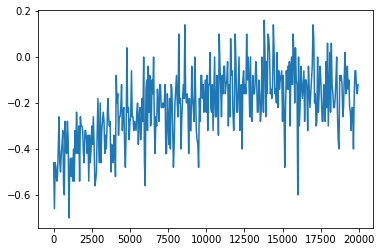

In [10]:
number_of_episodes = 20000
epsilon = 0.1

episodes = np.arange(0,number_of_episodes)
bin_means,_,_ = binned_statistic(episodes ,rewards, statistic="mean", bins =(number_of_episodes)/50, range=(0,number_of_episodes))
plt.plot(np.arange(0,number_of_episodes,50),bin_means)

